# DBSCAN Clustering and Random Forest Modeling

For my analysis, I am doing density based clustering utilizing an rbf_kernel distance matrix to capture non-linear and complex relationships between observations. After clustering, I will investigate the characteristics of the clusters to uncover insights about variables that may contribute to growth or decline of order volumes. I also utilize a random forest model to determine the features that contributed the most to the clusters to offer context to the clustering and potential insights into the clusters' characteristics.

In [ ]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
import numpy as np
from sklearn.cluster import DBSCAN
from scipy.spatial.distance import mahalanobis
from sklearn.metrics import pairwise_distances

In [ ]:
# prompt: mount drive to this location https://drive.google.com/file/d/1Q6Y6yB4f-0Vv4MSOdrvzg0pcLgMBUKL5/view?usp=drive_link

from google.colab import drive
drive.mount('/content/drive')


!cp -r '/content/drive/My Drive/U of U MSBA/Spring 2025/Capstone' '/content/'



Mounted at /content/drive


## Cleaning Data further

Here I clean the data a bit further than the initial EDA by creating dummy variables from our catergorical variables so it is compatible with the clustering algorithim. I also scale the numeric features of case_total, fountain_total, and percent_change so that these variables do not overly influence the clustering algorithim.

In [ ]:
#read csv
raw_completed = pd.read_csv('Capstone/complete_data.csv')
#raw_subset
raw_subset = pd.read_csv('Capstone/complete_data_subset.csv')

In [ ]:
def clean_data(df:pd.DataFrame):
  #get dummies for features and drop summary means
  raw_completed_dummies = pd.get_dummies(df, columns=['growth_category', 'TRADE_CHANNEL.x','COLD_DRINK_CHANNEL', 'SUB_TRADE_CHANNEL', 'FREQUENT_ORDER_TYPE'], drop_first=False, dtype=int
                ).drop(['SALES REP', 'CALL CENTER', 	'null',	'MYCOKE LEGACY',	'MYCOKE360',	'OTHER','EDI', 'CUSTOMER_NUMBER',	'total_order_2023',	'total_order_2024'], axis=1)
  try:
    raw_completed_dummies[['CO2_CUSTOMER', 'LOCAL_MARKET_PARTNER']] = raw_completed_dummies[['CO2_CUSTOMER', 'LOCAL_MARKET_PARTNER']].astype(int)
  except:
    print('segmented data... continuing')
  #drop duplicate column from join
  stg_completed = raw_completed_dummies.drop(['TRADE_CHANNEL.y'],axis=1)
  #replace infinity values with nulls
  stg_completed.replace([np.inf, -np.inf], np.nan, inplace=True)
  # Drop rows with NaN values
  stg_completed = stg_completed.dropna()
  #scale percent change growth for clustering
  scaler = StandardScaler()
  stg_completed['percent_change'] = scaler.fit_transform(stg_completed[['percent_change']])
  stg_completed['fountain_total'] = scaler.fit_transform(stg_completed[['fountain_total']])
  stg_completed['cases_total'] = scaler.fit_transform(stg_completed[['cases_total']])
  return stg_completed

In [ ]:
stg_completed=clean_data(raw_completed).drop('fountain_only', axis=1)
stg_complete_segment = clean_data(raw_subset)

segmented data... continuing


## DBSCAN Clustering

Here, we will create our density based clustering algorithim using an RBF kernel. We use this instead of the traditional euclidean disntance since we suspect the data to have non-linear relationship (RBF transforming data into a higher dimensional space to identify clusters with complex boundaries), to capture similarity along with distance (use of the similarity score in computing distance), and because RBF is better suited for high dimesional data, which we have with our ~90 dummy variables, due to its ability to focus on local relationships. RBF is also more robust to noise, which we seem to have plenty of within our dataset. Please note, this clustering algortihim used an altered dataset where customers with null values were removed from the dataset.

In [ ]:
def clusterData(gamma:float, df:pd.DataFrame, minsamps:int, eps:float):
  initial_df = df
  #get array of feature values
  X = initial_df.values
  from sklearn.metrics.pairwise import rbf_kernel

  # Compute the RBF kernel similarity matrix
  similarity_matrix = rbf_kernel(X, gamma=0.1)

  # Convert similarity to distance (1 - similarity)
  distance_matrix = 1 - similarity_matrix
  #played around with epsilion and min samples, .3 and 200 seemed to balance groups the best
  dbscan = DBSCAN(eps=eps, min_samples=minsamps, metric='precomputed')
  #create cluster labels
  labels = dbscan.fit_predict(distance_matrix)
  initial_df['Cluster'] = labels
  clustered_data = initial_df.copy(deep=True)
  #output counts per cluster
  print(clustered_data['Cluster'].value_counts())
  #remove unclassified
  clustered_cleaned = clustered_data[clustered_data['Cluster'] != -1]
  return clustered_cleaned

In [ ]:
clustered_completed = clusterData(0.1, stg_completed, 200, .3)

Cluster
 1     3526
 8     2729
-1     1648
 9     1424
 3     1375
 0     1169
 6      898
 2      876
 7      813
 4      682
 5      480
 12     404
 14     346
 11     311
 10     291
 13     270
Name: count, dtype: int64


In [ ]:
clustered_completed.to_csv('Capstone/clustered_complete.csv')

In [ ]:
clustered_subset = clusterData(.1, stg_complete_segment, 20, .2)

Cluster
 1    166
 0    153
-1    145
 3     62
 2     58
Name: count, dtype: int64


In [ ]:
clustered_subset.to_csv('Capstone/clustered_subset.csv')

## PCA Plotting of Clusters

Now, we will reduce the feature dimensionality using PCA to identify how the clusters are formed in relation to each other. Here in the chart, we are looking to see clusters spaced out from eachother, which indicates that each cluster posseses unique characteristics.

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
def plot_PCA(df:pd.DataFrame):
  np.random.seed(42)
  pca = PCA(n_components=2)
  reduced_data = pca.fit_transform(df)
  plt.scatter(reduced_data[:, 0], reduced_data[:, 1], c=df['Cluster'], cmap='viridis')
  for i, txt in enumerate(df['Cluster']):
      plt.annotate(txt, (reduced_data[i, 0], reduced_data[i, 1]), fontsize=8, alpha=0.7)

  plt.colorbar(label='Cluster')  # Add color legend for clusters
  plt.xlabel('Principal Component 1')
  plt.ylabel('Principal Component 2')
  plt.title('PCA Clustering Visualization')

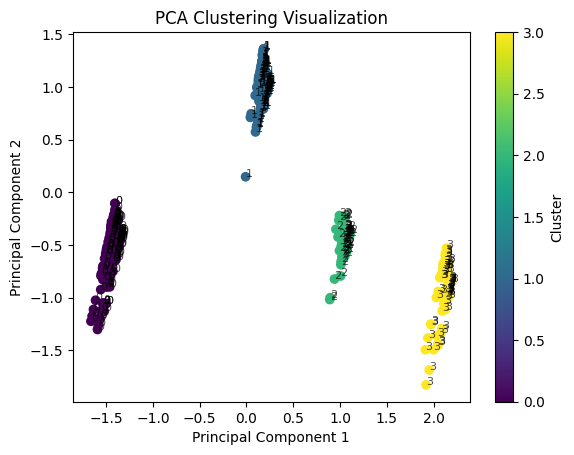

In [ ]:
plot_PCA(clustered_subset)

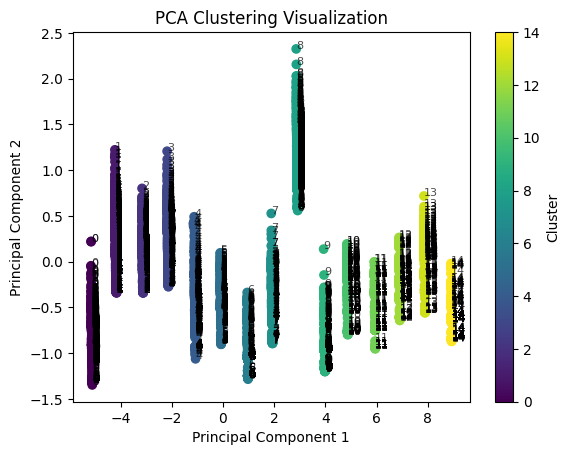

In [ ]:
plot_PCA(clustered_completed)

The PCA chart reveals distinct groupings across the principal components in both the segmented and completed datasets. This is a positive indication, as it suggests clear evidence that the clusters are well-defined and separate from one another. Now, let's take a look at some of the summary statistics of each.

## Random Forest: Variable Contribution to Clusters

Next, we run a random forest classifier to determine the which features seemed to contribute the most to the forming of the clusters.

In [ ]:
from sklearn.ensemble import RandomForestClassifier
np.random.seed(42)
def get_feature_importance(df: pd.DataFrame):
  #df = df.drop(['CUSTOMER_NUMBER'], axis=1)
  # Separate features and cluster labels
  X = df.drop('Cluster', axis=1)
  y = df['Cluster']

  # Train a random forest
  rf = RandomForestClassifier(random_state=42)
  rf.fit(X, y)

  # Get feature importances
  feature_importances = pd.Series(rf.feature_importances_, index=X.columns)
  print(feature_importances.sort_values(ascending=False).iloc[0:5])
  return feature_importances

In [ ]:
complete_feature_importance = get_feature_importance(clustered_completed)

TRADE_CHANNEL.x_FAST CASUAL DINING      0.094742
TRADE_CHANNEL.x_COMPREHENSIVE DINING    0.084353
SUB_TRADE_CHANNEL_FSR - MISC            0.074269
COLD_DRINK_CHANNEL_DINING               0.068318
TRADE_CHANNEL.x_GENERAL RETAILER        0.048437
dtype: float64


In [ ]:
subset_feature_importance = get_feature_importance(clustered_subset)

TRADE_CHANNEL.x_LICENSED HOSPITALITY            0.174963
TRADE_CHANNEL.x_COMPREHENSIVE DINING            0.161862
SUB_TRADE_CHANNEL_FSR - MISC                    0.152927
SUB_TRADE_CHANNEL_OTHER LICENSED HOSPITALITY    0.143088
TRADE_CHANNEL.x_OTHER DINING & BEVERAGE         0.106045
dtype: float64


From this, we can see that the 5 most important features in determing the clusters for the complete data were the trade channels of fast casual dining, comprehensive dining, and general retail. The groups were also heavily influenced by sub trade channel and the cold drink channel of dining.

As for the subset group, these seem to be more determined by the trade channels of lisenced hospitality, comprehensive dining, other dining and beverage; and the sub trade channels for misc and other lisencened hospitality.

We will save the top 10 characteristics to an object to explore the distirbution of these variables in the clusters later.

In [ ]:
top10characteristics_subset = subset_feature_importance.sort_values(ascending=False).iloc[0:10].index.tolist()
top10characteristics_complete = complete_feature_importance.sort_values(ascending=False).iloc[0:10].index.tolist()


## Investigating 10 largest clusters

Next, let's take a look at the mean of each feature by cluster. This may be a larger chart, but could be useful for deep-dives.

In [ ]:
def cluster_profiles(df: pd.DataFrame):
  np.random.seed(42)
  # Count the number of points in each cluster
  cluster_sizes = df['Cluster'].value_counts()

  # Select the top 10 largest clusters
  largest_clusters = cluster_sizes.head(10).index
  #print("Largest clusters:", largest_clusters)
  # Filter the DataFrame for the largest 10 clusters
  largest_clusters_data = df[df['Cluster'].isin(largest_clusters)]
  cluster_profiles = largest_clusters_data.groupby('Cluster').agg(['mean'])
  return cluster_profiles

In [ ]:
subset_profiles = cluster_profiles(clustered_subset)
subset_profiles

,percent_change,cases_total,fountain_total,growth_category_declined,growth_category_grew,growth_category_stayed_same,TRADE_CHANNEL.x_ACCOMMODATION,TRADE_CHANNEL.x_ACTIVITIES,TRADE_CHANNEL.x_BULK TRADE,TRADE_CHANNEL.x_COMPREHENSIVE DINING,TRADE_CHANNEL.x_EDUCATION,TRADE_CHANNEL.x_FAST CASUAL DINING,TRADE_CHANNEL.x_GENERAL RETAILER,TRADE_CHANNEL.x_GOURMET FOOD RETAILER,TRADE_CHANNEL.x_HEALTHCARE,TRADE_CHANNEL.x_INDUSTRIAL,TRADE_CHANNEL.x_LICENSED HOSPITALITY,TRADE_CHANNEL.x_MOBILE RETAIL,TRADE_CHANNEL.x_OTHER DINING & BEVERAGE,TRADE_CHANNEL.x_OUTDOOR ACTIVITIES,TRADE_CHANNEL.x_PROFESSIONAL SERVICES,TRADE_CHANNEL.x_PUBLIC SECTOR (NON-MILITARY),TRADE_CHANNEL.x_RECREATION,TRADE_CHANNEL.x_SPECIALIZED GOODS,TRADE_CHANNEL.x_TRAVEL,TRADE_CHANNEL.x_VEHICLE CARE,COLD_DRINK_CHANNEL_ACCOMMODATION,COLD_DRINK_CHANNEL_BULK TRADE,COLD_DRINK_CHANNEL_DINING,COLD_DRINK_CHANNEL_EVENT,COLD_DRINK_CHANNEL_GOODS,COLD_DRINK_CHANNEL_PUBLIC SECTOR,COLD_DRINK_CHANNEL_WELLNESS,COLD_DRINK_CHANNEL_WORKPLACE,SUB_TRADE_CHANNEL_ASIAN FAST FOOD,SUB_TRADE_CHANNEL_BULK TRADE,SUB_TRADE_CHANNEL_BURGER FAST FOOD,SUB_TRADE_CHANNEL_FAITH,SUB_TRADE_CHANNEL_FRATERNITY,SUB_TRADE_CHANNEL_FSR - MISC,SUB_TRADE_CHANNEL_GAME CENTER,SUB_TRADE_CHANNEL_MEXICAN FAST FOOD,SUB_TRADE_CHANNEL_MOBILE RETAIL,SUB_TRADE_CHANNEL_NON-RESTAURANT EDUCATION,SUB_TRADE_CHANNEL_OTHER ACCOMMODATION,SUB_TRADE_CHANNEL_OTHER DINING,SUB_TRADE_CHANNEL_OTHER FAST FOOD,SUB_TRADE_CHANNEL_OTHER GENERAL RETAIL,SUB_TRADE_CHANNEL_OTHER GOODS,SUB_TRADE_CHANNEL_OTHER GOURMET FOOD,SUB_TRADE_CHANNEL_OTHER HEALTHCARE,SUB_TRADE_CHANNEL_OTHER INDUSTRIAL,SUB_TRADE_CHANNEL_OTHER LICENSED HOSPITALITY,SUB_TRADE_CHANNEL_OTHER OUTDOOR ACTIVITIES,SUB_TRADE_CHANNEL_OTHER PROFESSIONAL SERVICES,SUB_TRADE_CHANNEL_OTHER PUBLIC SECTOR,SUB_TRADE_CHANNEL_OTHER RECREATION,SUB_TRADE_CHANNEL_OTHER TRAVEL,SUB_TRADE_CHANNEL_OTHER VEHICLE CARE,SUB_TRADE_CHANNEL_PIZZA FAST FOOD,SUB_TRADE_CHANNEL_RECREATION FILM,SUB_TRADE_CHANNEL_SANDWICH FAST FOOD,FREQUENT_ORDER_TYPE_CALL CENTER,FREQUENT_ORDER_TYPE_MYCOKE LEGACY,FREQUENT_ORDER_TYPE_MYCOKE360,FREQUENT_ORDER_TYPE_OTHER,FREQUENT_ORDER_TYPE_SALES REP
,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean
Cluster,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,-0.171615,0.0,0.115600,0.581699,0.398693,0.019608,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,1.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.013072,0.052288,0.124183,0.810458
1,-0.131268,0.0,-0.269973,0.596386,0.385542,0.018072,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.012048,0.018072,0.156627,0.813253
2,-0.313498,0.0,-0.206973,0.827586,0.120690,0.051724,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.103448,0.0,0.0,0.0,0.0,0.0,0.0,0.189655,0.0,0.0,0.0,0.0,0.448276,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.172414,0.0,0.086207,0.0,0.034483,0.051724,0.172414,0.741379
3,-0.059286,0.0,0.026702,0.548387,0.419355,0.032258,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,1.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.016129,0.096774,0.129032,0.758065


In [ ]:
complete_profiles = cluster_profiles(clustered_completed)
#complete_profiles.to_csv('Capstone/complete_profiles.csv')
complete_profiles

,percent_change,CO2_CUSTOMER,LOCAL_MARKET_PARTNER,cases_total,fountain_total,growth_category_declined,growth_category_grew,growth_category_stayed_same,TRADE_CHANNEL.x_ACADEMIC INSTITUTION,TRADE_CHANNEL.x_ACCOMMODATION,TRADE_CHANNEL.x_ACTIVITIES,TRADE_CHANNEL.x_BULK TRADE,TRADE_CHANNEL.x_COMPREHENSIVE DINING,TRADE_CHANNEL.x_DEFENSE,TRADE_CHANNEL.x_EDUCATION,TRADE_CHANNEL.x_FAST CASUAL DINING,TRADE_CHANNEL.x_GENERAL,TRADE_CHANNEL.x_GENERAL RETAILER,TRADE_CHANNEL.x_GOURMET FOOD RETAILER,TRADE_CHANNEL.x_HEALTHCARE,TRADE_CHANNEL.x_INDUSTRIAL,TRADE_CHANNEL.x_LICENSED HOSPITALITY,TRADE_CHANNEL.x_MOBILE RETAIL,TRADE_CHANNEL.x_OTHER DINING & BEVERAGE,TRADE_CHANNEL.x_OUTDOOR ACTIVITIES,TRADE_CHANNEL.x_PHARMACY RETAILER,TRADE_CHANNEL.x_PROFESSIONAL SERVICES,TRADE_CHANNEL.x_PUBLIC SECTOR (NON-MILITARY),TRADE_CHANNEL.x_RECREATION,TRADE_CHANNEL.x_SPECIALIZED GOODS,TRADE_CHANNEL.x_SUPERSTORE,TRADE_CHANNEL.x_TRAVEL,TRADE_CHANNEL.x_VEHICLE CARE,COLD_DRINK_CHANNEL_ACCOMMODATION,COLD_DRINK_CHANNEL_BULK TRADE,COLD_DRINK_CHANNEL_CONVENTIONAL,COLD_DRINK_CHANNEL_DINING,COLD_DRINK_CHANNEL_EVENT,COLD_DRINK_CHANNEL_GOODS,COLD_DRINK_CHANNEL_PUBLIC SECTOR,COLD_DRINK_CHANNEL_WELLNESS,COLD_DRINK_CHANNEL_WORKPLACE,SUB_TRADE_CHANNEL_ASIAN FAST FOOD,SUB_TRADE_CHANNEL_BOOKS & OFFICE,SUB_TRADE_CHANNEL_BULK TRADE,SUB_TRADE_CHANNEL_BURGER FAST FOOD,SUB_TRADE_CHANNEL_CHAIN STORE,SUB_TRADE_CHANNEL_CHICKEN FAST FOOD,SUB_TRADE_CHANNEL_CLUB,SUB_TRADE_CHANNEL_COMPREHENSIVE PROVIDER,SUB_TRADE_CHANNEL_CRUISE,SUB_TRADE_CHANNEL_FAITH,SUB_TRADE_CHANNEL_FRATERNITY,SUB_TRADE_CHANNEL_FSR - MISC,SUB_TRADE_CHANNEL_GAME CENTER,SUB_TRADE_CHANNEL_HIGH SCHOOL,SUB_TRADE_CHANNEL_HOME & HARDWARE,SUB_TRADE_CHANNEL_INDEPENDENT LOCAL STORE,SUB_TRADE_CHANNEL_MEXICAN FAST FOOD,SUB_TRADE_CHANNEL_MIDDLE SCHOOL,SUB_TRADE_CHANNEL_MISC,SUB_TRADE_CHANNEL_MOBILE RETAIL,SUB_TRADE_CHANNEL_NON-RESTAURANT EDUCATION,SUB_TRADE_CHANNEL_ONLINE STORE,SUB_TRADE_CHANNEL_OTHER ACADEMIC INSTITUTION,SUB_TRADE_CHANNEL_OTHER ACCOMMODATION,SUB_TRADE_CHANNEL_OTHER DINING,SUB_TRADE_CHANNEL_OTHER FAST FOOD,SUB_TRADE_CHANNEL_OTHER GENERAL RETAIL,SUB_TRADE_CHANNEL_OTHER GOODS,SUB_TRADE_CHANNEL_OTHER GOURMET FOOD,SUB_TRADE_CHANNEL_OTHER HEALTHCARE,SUB_TRADE_CHANNEL_OTHER INDUSTRIAL,SUB_TRADE_CHANNEL_OTHER LICENSED HOSPITALITY,SUB_TRADE_CHANNEL_OTHER MILITARY,SUB_TRADE_CHANNEL_OTHER OUTDOOR ACTIVITIES,SUB_TRADE_CHANNEL_OTHER PROFESSIONAL SERVICES,SUB_TRADE_CHANNEL_OTHER PUBLIC SECTOR,SUB_TRADE_CHANNEL_OTHER RECREATION,SUB_TRADE_CHANNEL_OTHER TRAVEL,SUB_TRADE_CHANNEL_OTHER VEHICLE CARE,SUB_TRADE_CHANNEL_PIZZA FAST FOOD,SUB_TRADE_CHANNEL_PRIMARY SCHOOL,SUB_TRADE_CHANNEL_RECREATION ARENA,SUB_TRADE_CHANNEL_RECREATION FILM,SUB_TRADE_CHANNEL_RECREATION PARK,SUB_TRADE_CHANNEL_RESIDENTIAL,SUB_TRADE_CHANNEL_SANDWICH FAST FOOD,FREQUENT_ORDER_TYPE_CALL CENTER,FREQUENT_ORDER_TYPE_EDI,FREQUENT_ORDER_TYPE_MYCOKE LEGACY,FREQUENT_ORDER_TYPE_MYCOKE360,FREQUENT_ORDER_TYPE_OTHER,FREQUENT_ORDER_TYPE_SALES REP
,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean
Cluster,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,-0.025317,0.439692,0.871685,-0.043222,-0.070740,0.511548,0.471343,0.017109,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.000000,0.0,0.001711,0.998289,0.0,0.00000,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000855,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.999145,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.00000

For this analysis, though, we will just look at which clusters had the highest means for each of the top 10 most "important" characteristics from our random forest model earlier.

In [ ]:
top10characteristics_subset.extend(['growth_category_declined', 'growth_category_grew', 'percent_change'])

In [ ]:
top10characteristics_complete.extend(['growth_category_declined', 'growth_category_grew', 'percent_change'])

In [ ]:
# Example: Find the highest mean value for each feature across the top clusters
def get_highest_means(df: pd.DataFrame, top10characteristics:list):
  np.random.seed(42)
  dominant_characteristics = df.idxmax(axis=0)  # Identify clusters with max mean for each feature

  pd.set_option('display.max_rows', None)  # Show all rows
  pd.set_option('display.max_columns', None) #show all columns
  summary_clusters = pd.DataFrame(dominant_characteristics).reset_index(drop=False).rename({'level_0': 'Variable','level_1': 'summary Stat', 0:'Cluster with Highest Mean:'}, axis=1)
  summary_clusters_top_10 = summary_clusters[summary_clusters['Variable'].isin(top10characteristics)]
  return summary_clusters, summary_clusters_top_10

In [ ]:
subset_all_summary, subset_top10_summary = get_highest_means(subset_profiles, top10characteristics_subset)
subset_top10_summary.sort_values(by='Cluster with Highest Mean:')

,Variable,summary Stat,Cluster with Highest Mean:
2,fountain_total,mean,0
9,TRADE_CHANNEL.x_COMPREHENSIVE DINING,mean,0
39,SUB_TRADE_CHANNEL_FSR - MISC,mean,0
16,TRADE_CHANNEL.x_LICENSED HOSPITALITY,mean,1
52,SUB_TRADE_CHANNEL_OTHER LICENSED HOSPITALITY,mean,1
46,SUB_TRADE_CHANNEL_OTHER FAST FOOD,mean,2
11,TRADE_CHANNEL.x_FAST CASUAL DINING,mean,2
3,growth_category_declined,mean,2
41,SUB_TRADE_CHANNEL_MEXICAN FAST FOOD,mean,2
18,TRADE_CHANNEL.x_OTHER DINING & BEVERAGE,mean,3


For the subsetted dataset, we can see that group 0 had the highest means for fountain total, comprehensive dining, and fsr-misc. Another stand-out cluster was cluster 2, which has the highest means for the fast food groups, but also showed as the cluster with the most observations declining in growth. Cluster 3 had the highest mean for percent change, which included the highest proportions of dining and beverage and other dining.

In [ ]:
complete_all_summary, complete_top_10_summary = get_highest_means(complete_profiles, top10characteristics_complete)
complete_top_10_summary.sort_values(by='Cluster with Highest Mean:')


,Variable,summary Stat,Cluster with Highest Mean:
75,SUB_TRADE_CHANNEL_OTHER OUTDOOR ACTIVITIES,mean,0
5,growth_category_declined,mean,1
36,COLD_DRINK_CHANNEL_DINING,mean,1
15,TRADE_CHANNEL.x_FAST CASUAL DINING,mean,1
21,TRADE_CHANNEL.x_LICENSED HOSPITALITY,mean,2
66,SUB_TRADE_CHANNEL_OTHER DINING,mean,3
23,TRADE_CHANNEL.x_OTHER DINING & BEVERAGE,mean,3
0,percent_change,mean,3
6,growth_category_grew,mean,4
38,COLD_DRINK_CHANNEL_GOODS,mean,6


In the complete dataset, Groups 1, 3, and 8 had the highest concentrations of key characteristics. Group 3 stood out the most, dominating the Other Dining and Other Dining and Beverage categories, and posting the highest mean percent change in growth—indicating strong positive momentum. Group 1 showed the highest average values for Dining and Fast Casual Dining, but also had the largest proportion of observations with declining growth. This contrast may suggest that while fast food chains are still significant, they could be facing headwinds and may require additional support, whereas alternative dining segments appear to be on a faster growth trajectory.

## Deep Diving Clusters

First we will look at the fast food/declining group clusters in both of our datasets.

### Declining Clusters

In [ ]:
subset_all_summary[subset_all_summary['Cluster with Highest Mean:'] == 2]

,Variable,summary Stat,Cluster with Highest Mean:
3,growth_category_declined,mean,2
5,growth_category_stayed_same,mean,2
11,TRADE_CHANNEL.x_FAST CASUAL DINING,mean,2
34,SUB_TRADE_CHANNEL_ASIAN FAST FOOD,mean,2
41,SUB_TRADE_CHANNEL_MEXICAN FAST FOOD,mean,2
46,SUB_TRADE_CHANNEL_OTHER FAST FOOD,mean,2
59,SUB_TRADE_CHANNEL_PIZZA FAST FOOD,mean,2
61,SUB_TRADE_CHANNEL_SANDWICH FAST FOOD,mean,2
63,FREQUENT_ORDER_TYPE_MYCOKE LEGACY,mean,2
65,FREQUENT_ORDER_TYPE_OTHER,mean,2


Cluster 2 shows the highest proportions of staying the same AND declining of the clusters. Additionally, it contained all the fast food groups for trade channels. Additionally, it also contained the highest proportions of MYCOKE legacy and other frequent order types of the clusters.

Let's compare it to the overall data for a similar cluster, 1.

In [ ]:
complete_all_summary[complete_all_summary['Cluster with Highest Mean:'] == 1]

,Variable,summary Stat,Cluster with Highest Mean:
5,growth_category_declined,mean,1
15,TRADE_CHANNEL.x_FAST CASUAL DINING,mean,1
36,COLD_DRINK_CHANNEL_DINING,mean,1
42,SUB_TRADE_CHANNEL_ASIAN FAST FOOD,mean,1
45,SUB_TRADE_CHANNEL_BURGER FAST FOOD,mean,1
47,SUB_TRADE_CHANNEL_CHICKEN FAST FOOD,mean,1
58,SUB_TRADE_CHANNEL_MEXICAN FAST FOOD,mean,1
67,SUB_TRADE_CHANNEL_OTHER FAST FOOD,mean,1
81,SUB_TRADE_CHANNEL_PIZZA FAST FOOD,mean,1
87,SUB_TRADE_CHANNEL_SANDWICH FAST FOOD,mean,1


Again, we see many of the same characteristics, with cluster 1 having the highest proportions of fast food trade channels and using mycoke legacy. This could offer evidence that fast food chains may be declining in overall ordered gallons, potentially due to them using legacy systems.

Let's examine our high growth clusters in each of the datasets to determine if there are characteristics shared by high performing clusters.

### Rising Clusters

Finally, we will dive into the cluster with the highest proportion of increasing growth

In [ ]:
subset_all_summary[subset_all_summary['Cluster with Highest Mean:'] == 3]

,Variable,summary Stat,Cluster with Highest Mean:
0,percent_change,mean,3
4,growth_category_grew,mean,3
18,TRADE_CHANNEL.x_OTHER DINING & BEVERAGE,mean,3
45,SUB_TRADE_CHANNEL_OTHER DINING,mean,3
64,FREQUENT_ORDER_TYPE_MYCOKE360,mean,3


In the subset dataset for the cluster with the highest mean for percent change, we see it also has the highest mean for the binary variable of growth_category_grew, indicating that the clustering algroithim is picking up on the correlation between those two variables. Additionally, we also see the other dining channels from the top 10 features analysis. Most interestingly, however, is the highest proportion of mycoke360. Seeing as the declining growth cluster had the highest proportion of mycoke360 legacy version, this could offer insight that mycoke360 upgrades could improve growth as high performers seem to be using it.

Finally, let's look at the overall data's cluster with the highest mean growth, which was cluster 4.

In [ ]:
complete_all_summary[complete_all_summary['Cluster with Highest Mean:'] == 4
]

,Variable,summary Stat,Cluster with Highest Mean:
3,cases_total,mean,4
6,growth_category_grew,mean,4
16,TRADE_CHANNEL.x_GENERAL,mean,4
34,COLD_DRINK_CHANNEL_BULK TRADE,mean,4
49,SUB_TRADE_CHANNEL_COMPREHENSIVE PROVIDER,mean,4


Here we see that cluster 4 contained the most growers but also contained the highest proportions for case total, general trade channel, cold drink trade channel, and the sub trade channel of comprehensive provider.

Before, we end our analysis of the clusters in each of the datasets, we will check to see if the group that did have coke360 in the overall data tended to perform better than average on growth.

In [ ]:
complete_all_summary[complete_all_summary['Variable'] == 'FREQUENT_ORDER_TYPE_MYCOKE360']

,Variable,summary Stat,Cluster with Highest Mean:
91,FREQUENT_ORDER_TYPE_MYCOKE360,mean,5


In [ ]:
five_v_all = pd.concat([complete_profiles.mean(), complete_profiles.loc[5].sort_values()], axis=1)

In [ ]:
five_v_all['delta'] = five_v_all[5] - five_v_all[0]

In [ ]:
five_v_all[five_v_all['delta'] != 0].sort_values(by='delta', key=abs, ascending=False).rename({0:'Mean of Means of all Other Clusters', 5:'Cluster 5 mean'}, axis=1)

,,Mean of Means of all Other Clusters,Cluster 5 mean,delta
TRADE_CHANNEL.x_PROFESSIONAL SERVICES,mean,0.100000,1.000000,0.900000
COLD_DRINK_CHANNEL_WORKPLACE,mean,0.100000,1.000000,0.900000
SUB_TRADE_CHANNEL_OTHER PROFESSIONAL SERVICES,mean,0.100000,1.000000,0.900000
COLD_DRINK_CHANNEL_DINING,mean,0.400611,0.000000,-0.400611
FREQUENT_ORDER_TYPE_SALES REP,mean,0.693944,0.352083,-0.341861
FREQUENT_ORDER_TYPE_OTHER,mean,0.182965,0.447917,0.264951
CO2_CUSTOMER,mean,0.410155,0.625000,0.214845
COLD_DRINK_CHANNEL_GOODS,mean,0.200000,0.000000,-0.200000
TRADE_CHANNEL.x_OUTDOOR ACTIVITIES,mean,0.100000,0.000000,-0.100000
TRADE_CHANNEL.x_ACCOMMODATION,mean,0.100000,0.000000,-0.100000


Looking at the characteristics of cluster 5, we can see that group actually seemed have a very slightly higher mean of declining customers than the average cluster mean. So while MyCoke360 may be conducive to growth in local fountain customers, that may not apply to the overall population.



## Summary of Results

From the clustering analysis, we found that in the local market partner and fountain drink only subset, the cluster with the highest growth contained the highest proprtions of MyCoke360 users in the other channels. Whereas the cluster with the highest proportion of declining growth also was had the highest proportions of fast food trade channels and the use of MyCoke360 - Legacy.

In the overall population, we saw that the cluster with the highest average growth also had the highest proportions of other trade channels as well, but did not use MyCoke360 more than other clusters. When investigating the group that did have the highest proportion of MyCoke360 order types, it did not seem to exhibit as much growth as the as the other clusters. This may offer evidence that upgrading MyCoke360 may be worthwhile in the subsetted sample, but may not have as drastic of an effect in the general population of customers.

Additionally, we found that both the subsetted and complete datasets seemed to cluster the "OTHER" trade channels in the highest-mean-growth cluster, which may indicate promise for these companies for growing order volumes. Additionally, both datasets showed the cluster with the highest proportion of declining-order-volume customers also contained the highest proportions of many of the "FAST FOOD" order channels. This could indicate that the fast food channels may be declining in order volume and could benefit through coaching or upgrading their ordering systems, as suggested by the subsetted analysis showing a distinct difference in growth in the clusters most utilizing MyCoke360 vs. MyCoke360 Legacy.

# Next Steps: Modeling for Sales Rep Impact

After clustering was completed, we ran a correlation analysis comparing the proportion of growing companies with the proportion of certain characteristics across clusters. This led to the discover that sales reps had a high, positive correlation with the proportion of growers in a cluster - demonstrated below. We filtered our correlation analysis down to Frequent order channels, as this factor we deemed to be controllable by Swire, whereas Swire cannot control other characteristics like the business type of the customer.

In [ ]:
complete_profiles.columns = complete_profiles.columns.droplevel(1)


In [ ]:
characteristics = complete_profiles.drop(['growth_category_grew'], axis=1).astype(float)
correlations = characteristics.corrwith(complete_profiles['growth_category_grew'].astype(float))
correlation_df = correlations.to_frame(name='correlation_with_growers').reset_index(drop=False).rename({'index':'Variable'},axis=1)
correlation_df.loc[correlation_df['Variable'].str.contains('FREQUENT')].sort_values(by = 'correlation_with_growers', ascending=False)


/usr/local/lib/python3.11/dist-packages/numpy/lib/_function_base_impl.py:2922: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/usr/local/lib/python3.11/dist-packages/numpy/lib/_function_base_impl.py:2923: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


,Variable,correlation_with_growers
87,FREQUENT_ORDER_TYPE_CALL CENTER,0.180536
92,FREQUENT_ORDER_TYPE_SALES REP,0.105910
90,FREQUENT_ORDER_TYPE_MYCOKE360,0.046446
91,FREQUENT_ORDER_TYPE_OTHER,-0.061273
88,FREQUENT_ORDER_TYPE_EDI,-0.330148
89,FREQUENT_ORDER_TYPE_MYCOKE LEGACY,-0.562860


We found that Sales Reps, call centers, and MyCoke360s had strong correlations with customer growth. To better understand their impact, we estimated the individual (heterogeneous) treatment effect of each trade channel using a T-learner approach. This involved training separate Random Forest models for treated and untreated customers to predict the effect of using the Sales Rep channel on average gallons per year.

In [ ]:
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import NearestNeighbors
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LassoCV
from sklearn.preprocessing import StandardScaler
import statsmodels.api as sm


We also switch our dataset to include a median-imputed dataset for calculating the average treatment effect. This was to ensure a more holistic view of the customer population and ensure we could have enough observations between classes (treated and untreated) to train our models.

In [ ]:
#load in median imputed dataset
raw_completed = pd.read_csv('Capstone/profile_all_cleaned.csv')

The next section of code prepares a customer dataset for analysis by one-hot encoding key categorical columns, dropping fields unrelated to our analysis, and ensuring binary flags are stored as integers. It then creates a scaled version of the dataset by standardizing selected numerical features like percent change and total gallons using z-scores, to ensure numerical varoiables do not impact the algorithims. This preprocessing ensures the data is clean and ready for modeling or clustering.

In [ ]:
#creating dummy variables
raw_completed_dummies = pd.get_dummies(raw_completed, columns=['FREQUENT_ORDER_TYPE', 'TRADE_CHANNEL'
  ,'COLD_DRINK_CHANNEL', 'SUB_TRADE_CHANNEL'], drop_first=False, dtype=int)
raw_completed_dummies = raw_completed_dummies.drop(['PRIMARY_GROUP_NUMBER', 'FIRST_DELIVERY_DATE',	'ON_BOARDING_DATE', 'ZIP_CODE'], axis=1)
raw_completed_dummies[['CO2_CUSTOMER', 'LOCAL_MARKET_PARTNER', 'threshold_400_gal', 'fountain_only']] = raw_completed_dummies[['CO2_CUSTOMER', 'LOCAL_MARKET_PARTNER', 'threshold_400_gal', 'fountain_only']].astype(int)
scaler = StandardScaler()
#scaling numerical veriables and creating new dataframe for these
raw_completed_dummies_scaled = raw_completed_dummies.copy(deep=True)
raw_completed_dummies_scaled['percent_change'] = scaler.fit_transform(raw_completed_dummies_scaled[['percent_change']])
raw_completed_dummies_scaled['fountain_total'] = scaler.fit_transform(raw_completed_dummies_scaled[['fountain_total']])
raw_completed_dummies_scaled['cases_total'] = scaler.fit_transform(raw_completed_dummies_scaled[['cases_total']])
raw_completed_dummies_scaled['total_gal_2024'] = scaler.fit_transform(raw_completed_dummies_scaled[['total_gal_2024']])
raw_completed_dummies_scaled['total_gal_2023'] = scaler.fit_transform(raw_completed_dummies_scaled[['total_gal_2023']])
# raw_completed_dummies['avg_gal_per_year'] = scaler.fit_transform(raw_completed_dummies[['avg_gal_per_year']])
#raw_completed_dummies.to_csv('dummies_completed_profile.csv', index=False)

Next, we filtered the dataset to include only customers averaging under 400 gallons per year. This threshold aligns with the current red-truck/white-truck cutoff, allowing us to focus on customers who may be at risk of being reassigned to white truck service under the status quo.

In [ ]:
under400Data_Scaled = raw_completed_dummies_scaled[raw_completed_dummies_scaled['avg_gal_per_year'] <= 400]
under400Data_UnScaled = raw_completed_dummies[raw_completed_dummies['avg_gal_per_year'] <= 400]

## Function for T-Learner for HTE, Random Forest for Feature Importance, and Lasso for magnitude and direction.

The function below runs a causal inference pipeline using a T-learner approach to estimate the individual treatment effect (HTE) of a binary variable, which will be each of the frequent order channels we found to be positively correlated. It builds separate Random Forest models for treated and untreated groups, computes ITEs, and then fits both a Random Forest and Lasso regression to analyze which features best explain the variation in treatment effect. Finally, it returns the full dataset with ITEs and the most influential features identified by Lasso.










In [ ]:
def analysis_ps_tree_lasso(column:str, scaled_df:pd.DataFrame(), unscaled_df:pd.DataFrame()):
  print('\n-------------------RESULT SET FOR ' + column + '-----------------------------')
  from sklearn.metrics import r2_score, mean_squared_error
  # Step 1: Define features (X), treatment (W), and outcome (y)
  X = scaled_df.drop(columns=[column, 'CUSTOMER_NUMBER', 'cases_total', 'fountain_total', 'total_gal_2024', 'total_gal_2023', 'percent_change', 'avg_gal_per_year'])
  W = scaled_df[column]  # treatment indicator (1 = treated, 0 = untreated)
  y = scaled_df['avg_gal_per_year']  # outcome
  print('Average Gallons a year for treated customers:', y[W == 1].mean())  # Average gallons for treated customers
  print('Average Gallons a year for untreated customers:', y[W == 0].mean())  # Average gallons for untreated customers
  # Step 2: Train two separate models: one for treated, one for untreated (T-learner)

  # Split treated and untreated groups
  X_treated = X[W == 1]
  y_treated = y[W == 1]

  X_untreated = X[W == 0]
  y_untreated = y[W == 0]

  # Train Random Forest on treated
  treated_model = RandomForestRegressor(
      n_estimators=1000,
      max_depth=None,
      min_samples_leaf=2,
      random_state=42
  )
  treated_model.fit(X_treated, y_treated)

  # Train Random Forest on untreated
  untreated_model = RandomForestRegressor(
      n_estimators=1000,
      max_depth=None,
      min_samples_leaf=2,
      random_state=42
  )
  untreated_model.fit(X_untreated, y_untreated)


  # Step 3: Predict and calculate R² scores
  y_pred_treated = treated_model.predict(X_treated)
  y_pred_untreated = untreated_model.predict(X_untreated)

  r2_treated = r2_score(y_treated, y_pred_treated)
  r2_untreated = r2_score(y_untreated, y_pred_untreated)

  print(f"R² Score for Treated Model: {r2_treated:.3f}")
  print(f"R² Score for Untreated Model: {r2_untreated:.3f}")
  # Step 3: Predict potential outcomes
  mu_1 = treated_model.predict(X)     # Predicted outcome if treated
  mu_0 = untreated_model.predict(X)   # Predicted outcome if untreated

  # Step 4: Estimate Individual Treatment Effect (ITE)
  individual_treatment_effects = mu_1 - mu_0

  # Step 5: Copy original dataframe and insert ITE
  matched_df = scaled_df.copy()  # ← Make sure you're copying the dataframe you're actually working on
  matched_df['treatment_effect'] = individual_treatment_effects

  print('MEAN CATE: ' +str(individual_treatment_effects.mean()))

  forModels_unscaled = matched_df[['CUSTOMER_NUMBER', 'treatment_effect']].dropna().merge(unscaled_df, on=['CUSTOMER_NUMBER'], how='inner')
  forModels_scaled = matched_df.dropna()

  X = forModels_scaled.drop(columns=[column, 'CUSTOMER_NUMBER', 'avg_gal_per_year', 'treatment_effect'
  , 'total_gal_2023', 'total_gal_2024', 'percent_change'])
  y = forModels_scaled['treatment_effect']

  # Train/test split (optional)
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

  # Train a Random Forest
  rf = RandomForestRegressor(n_estimators=200, max_depth=10, random_state=42)
  rf.fit(X_train, y_train)

  # Predict on test set
  y_pred = rf.predict(X_test)

  # Evaluate model
  rmse = np.sqrt(mean_squared_error(y_test, y_pred))
  # Evaluate model
  print('-----------------Tree Results----------------\n')
  print(f"R2 Score: {r2_score(y_test, y_pred):.3f}")
  print(f"RMSE: {np.sqrt(mean_squared_error(y_test, y_pred)):.2f}")
  importances = rf.feature_importances_
  feature_names = X.columns

  # Create a DataFrame of feature importances
  feature_importances = pd.DataFrame({
      'feature': feature_names,
      'importance': importances
  }).sort_values(by='importance', ascending=False)

  print(feature_importances)

  #OLS model for looking at relationship between cases and fountain total and treatment that was cut in final analysis.
  # import statsmodels.api as sm

  # X = forModels_unscaled[['cases_total', 'fountain_total']]
  # X = sm.add_constant(X)
  # y = forModels_unscaled['treatment_effect']

  # model = sm.OLS(y, X).fit()
  # print('--------------------OLS Model of case and Fountain--------------------')
  # print(model.summary())

  print('----------------------Lasso Regression with Coefficents for Features--------------------------')
  X = forModels_scaled.drop(columns=[column, 'cases_total', 'fountain_total', 'CUSTOMER_NUMBER', 'avg_gal_per_year', 'treatment_effect'
  , 'total_gal_2023', 'total_gal_2024', 'percent_change'])
  y = forModels_scaled['treatment_effect']
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

  # Train Lasso with cross-validation
  lasso = LassoCV(cv=5, random_state=42)
  lasso.fit(X_train, y_train)

  # Predict on test set
  y_pred = lasso.predict(X_test)


  print(f"R2 Score: {r2_score(y_test, y_pred):.3f}")
  print(f"RMSE: {np.sqrt(mean_squared_error(y_test, y_pred)):.2f}")
  print(f"Best Alpha: {lasso.alpha_:.4f}")

    # Coefficients
  coef = pd.Series(lasso.coef_, index=X.columns)

  # Only show non-zero coefficients (features Lasso selected)
  selected_features = coef[coef != 0].sort_values(ascending=False)
  print(selected_features)

  return matched_df, selected_features

We then use the function declared above to test the 3 main treatments were decided upon. Ideally, we are looking for a treatment with a high conditional average treatement effect across our population.

In [ ]:
for treatment in ['FREQUENT_ORDER_TYPE_SALES REP','FREQUENT_ORDER_TYPE_MYCOKE360', 'FREQUENT_ORDER_TYPE_CALL CENTER' ]:
  analysis_ps_tree_lasso(column=treatment, scaled_df=under400Data_Scaled, unscaled_df=under400Data_UnScaled)


-------------------RESULT SET FOR FREQUENT_ORDER_TYPE_SALES REP-----------------------------
Average Gallons a year for treated customers: 128.8275626373684
Average Gallons a year for untreated customers: 115.80572399009263
R² Score for Treated Model: 0.109
R² Score for Untreated Model: 0.235
MEAN CATE: 22.4412331713491
-----------------Tree Results----------------

R2 Score: 0.680
RMSE: 18.14
                                          feature    importance
10                      FREQUENT_ORDER_TYPE_OTHER  2.656462e-01
73         SUB_TRADE_CHANNEL_OTHER GENERAL RETAIL  8.383682e-02
7                         FREQUENT_ORDER_TYPE_EDI  7.121766e-02
28               TRADE_CHANNEL_OUTDOOR ACTIVITIES  6.678926e-02
0                            LOCAL_MARKET_PARTNER  5.012350e-02
5                                   fountain_only  4.793007e-02
86           SUB_TRADE_CHANNEL_OTHER VEHICLE CARE  4.631663e-02
1                                    CO2_CUSTOMER  4.421121e-02
36                     TRA

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4480.716252559796, tolerance: 1774.966586502053
  model = cd_fast.enet_coordinate_descent_gram(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4830.282195992768, tolerance: 1774.966586502053
  model = cd_fast.enet_coordinate_descent_gram(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4792.815915005282, tolerance: 1774.966586502053
  model = cd_fast.enet_coordinate_descent_gram(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWar

R2 Score: 0.403
RMSE: 26.97
Best Alpha: 0.0033
SUB_TRADE_CHANNEL_HIGH SCHOOL                    67.712952
TRADE_CHANNEL_EDUCATION                          63.986105
COLD_DRINK_CHANNEL_GOODS                         60.276870
FREQUENT_ORDER_TYPE_MYCOKE LEGACY                49.529443
SUB_TRADE_CHANNEL_FAITH                          43.506835
SUB_TRADE_CHANNEL_OTHER TRAVEL                   40.932329
TRADE_CHANNEL_BULK TRADE                         37.027242
SUB_TRADE_CHANNEL_CHICKEN FAST FOOD              36.887079
SUB_TRADE_CHANNEL_RECREATION ARENA               36.803809
FREQUENT_ORDER_TYPE_CALL CENTER                  32.090045
SUB_TRADE_CHANNEL_FRATERNITY                     30.342985
COLD_DRINK_CHANNEL_WORKPLACE                     29.682843
SUB_TRADE_CHANNEL_SANDWICH FAST FOOD             25.319526
TRADE_CHANNEL_OUTDOOR ACTIVITIES                 22.901367
SUB_TRADE_CHANNEL_OTHER PUBLIC SECTOR            18.477921
SUB_TRADE_CHANNEL_MOBILE RETAIL                  16.763190
SUB_TRADE

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.828e+04, tolerance: 3.052e+03
  model = cd_fast.enet_coordinate_descent(


From the analysis, Sales Rep was the only treatment with a positive conditional average treatment effect (22.44 average gallons a year), indicating a consistent uplift in average gallons sold across customers. As a result, we focused our analysis on this treatment due to its reliably positive impact.

The next cell extracts a dataframe with treatment effect added to the characteristics and a dataframe of the selected features from the lasso regression from the sales rep model from the model above.

In [ ]:
sales_rep_matched_df, sales_rep_selected_features = analysis_ps_tree_lasso(column='FREQUENT_ORDER_TYPE_SALES REP', scaled_df=under400Data_Scaled, unscaled_df=under400Data_UnScaled)


-------------------RESULT SET FOR FREQUENT_ORDER_TYPE_SALES REP-----------------------------
Average Gallons a year for treated customers: 128.8275626373684
Average Gallons a year for untreated customers: 115.80572399009263
R² Score for Treated Model: 0.109
R² Score for Untreated Model: 0.235
MEAN CATE: 22.4412331713491
-----------------Tree Results----------------

R2 Score: 0.680
RMSE: 18.14
                                          feature    importance
10                      FREQUENT_ORDER_TYPE_OTHER  2.656462e-01
73         SUB_TRADE_CHANNEL_OTHER GENERAL RETAIL  8.383682e-02
7                         FREQUENT_ORDER_TYPE_EDI  7.121766e-02
28               TRADE_CHANNEL_OUTDOOR ACTIVITIES  6.678926e-02
0                            LOCAL_MARKET_PARTNER  5.012350e-02
5                                   fountain_only  4.793007e-02
86           SUB_TRADE_CHANNEL_OTHER VEHICLE CARE  4.631663e-02
1                                    CO2_CUSTOMER  4.421121e-02
36                     TRA

## Analysis of Sales Rep Impact on Individual Treatment Effect

Next, we isolated our treatment effects to customers who were not already on the sales rep order channel to see this subset's CATE.

In [ ]:
#output mean treatment effect for those not currently using sales rep
sales_rep_matched_df.loc[sales_rep_matched_df['FREQUENT_ORDER_TYPE_SALES REP'] == 0, 'treatment_effect'].mean()

np.float64(9.655537734503262)

A positive value of 9.66 indicates that on average, according to our model, customers who are not currently on the sales rep channel and who are under 400 gallons a year improve by 9.66 average gallons a year. This continues to offer evidence that a switch to sales rep will positively impact growth.

We also explored which characteristics most influenced the magnitude of the treatment effect by examining the features selected by our Lasso regression. Although the T-learner models had low R² values, the Lasso model achieved a improved R² of 0.4, suggesting that the direction and relative importance of the coefficients could help identify customers who may benefit most from a Sales Rep relationship.


In [ ]:
#disp
sales_rep_selected_features.reset_index().rename({'index': 'Variable', 0:'Coefficent'}, axis=1).head(5)

,Variable,Coefficent
0,COLD_DRINK_CHANNEL_WELLNESS,47.587788
1,SUB_TRADE_CHANNEL_MIDDLE SCHOOL,45.247856
2,SUB_TRADE_CHANNEL_BOOKS & OFFICE,35.314144
3,TRADE_CHANNEL_GENERAL RETAILER,32.575025
4,SUB_TRADE_CHANNEL_PRIMARY SCHOOL,32.496940


We then utilized these numbers to report some of our intial findings with potential uplift of customer. Note that these coefficents may be slightly different than those shared in the presentation as a seed was not set. However, the variables we reported on still demonstrate a high coefficent and fall within the top 5 highest variable coefficents.

## Concluding Remarks

Based on our analysis, we recommend two actions for Swire. First, target customers under the 400-gallon threshold highlighted here by shifting them to the Sales Rep Frequent Order channel, which shows strong potential to boost their performance.

However, and perhaps more importantly, we suggest Swire adopt our method of estimating treatment effects across customers to identify which interventions — whether specific sales reps or order channels — yield positive outcomes. This approach enables Swire to proactively tailor strategies to retain and grow customers, rather than disengaging from those who could thrive with the right support.

In [ ]:

!jupyter nbconvert --to html "/content/drive/MyDrive/Colab Notebooks/Dan_Modeling.ipynb" --output "/content/drive/MyDrive/Colab Notebooks/Dan_Modeling.html"


[NbConvertApp] Converting notebook /content/drive/MyDrive/Colab Notebooks/Dan_Modeling.ipynb to html
[NbConvertApp] WARNING | Alternative text is missing on 2 image(s).
[NbConvertApp] Writing 728408 bytes to /content/drive/MyDrive/Colab Notebooks/Dan_Modeling.html
